In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

# Шаг 1: Загружаем данные

In [2]:
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN']
data = yf.download(tickers, start="2020-01-01", end="2024-12-31")

C:\Users\pluso\AppData\Local\Temp\ipykernel_23288\1298712397.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  4 of 4 completed


In [3]:
data.head(3)

Price           Close                                         High             \
Ticker           AAPL       AMZN        MSFT       TSLA       AAPL       AMZN   
Date                                                                            
2020-01-02  72.620834  94.900497  153.042313  28.684000  72.681281  94.900497   
2020-01-03  71.914825  93.748497  151.136627  29.534000  72.676454  94.309998   
2020-01-06  72.487854  95.143997  151.527298  30.102667  72.526541  95.184502   

Price                                    Low                         \
Ticker            MSFT       TSLA       AAPL       AMZN        MSFT   
Date                                                                  
2020-01-02  153.147124  28.713333  71.373211  93.207497  150.860356   
2020-01-03  152.403882  30.266666  71.689965  93.224998  150.603049   
2020-01-06  151.594002  30.104000  70.783256  93.000000  149.126182   

Price                       Open                                       Volume  \
Ticker           TSLA       AAPL       AMZN        MSFT       TSLA       AAPL   
Date                                                                            
2020-01-02  28.114000  71.627084  93.750000  151.289123  28.299999  135480400   
2020-01-03  29.128000  71.847125  93.224998  150.850792  29.366667  146322800   
2020-01-06  29.333332  71.034717  93.000000  149.669298  29.364668  118387200   

Price                                      
Ticker          AMZN      MSFT       TSLA  
Date                                       
2020-01-02  80580000  22622100  142981500  
2020-01-03  75288000  21116200  266677500  
2020-01-06  81236000  20813700  151995000

In [4]:
data_close = data['Close']
data_close

Ticker,AAPL,AMZN,MSFT,TSLA
Date,,,,
2020-01-02,72.620834,94.900497,153.042313,28.684000
2020-01-03,71.914825,93.748497,151.136627,29.534000
2020-01-06,72.487854,95.143997,151.527298,30.102667
2020-01-07,72.146942,95.343002,150.145721,31.270666
2020-01-08,73.307533,94.598503,152.537277,32.809334
...,...,...,...,...
2024-12-23,254.655716,225.059998,433.583038,430.600006
2024-12-24,257.578674,229.050003,437.647369,462.279999
2024-12-26,258.396667,227.050003,436.432068,454.130005


In [5]:
returns = data_close.pct_change().dropna()
returns

Ticker,AAPL,AMZN,MSFT,TSLA
Date,,,,
2020-01-03,-0.009722,-0.012139,-0.012452,0.029633
2020-01-06,0.007968,0.014886,0.002585,0.019255
2020-01-07,-0.004703,0.002092,-0.009118,0.038801
2020-01-08,0.016086,-0.007809,0.015928,0.049205
2020-01-09,0.021240,0.004799,0.012493,-0.021945
...,...,...,...,...
2024-12-23,0.003065,0.000622,-0.003092,0.022657
2024-12-24,0.011478,0.017729,0.009374,0.073572
2024-12-26,0.003176,-0.008732,-0.002777,-0.017630


# 2. Вычисление статистик

In [6]:
mean_returns = returns.mean() * 252  # годовые
cov_matrix = returns.cov() * 252     # годовые

In [7]:
mean_returns

Ticker
AAPL    0.299545
AMZN    0.234575
MSFT    0.250702
TSLA    0.762471
dtype: float64

In [8]:
cov_matrix

Ticker,AAPL,AMZN,MSFT,TSLA
Ticker,,,,
AAPL,0.100420,0.067507,0.072340,0.102752
AMZN,0.067507,0.129425,0.074460,0.104534
MSFT,0.072340,0.074460,0.093067,0.091489
TSLA,0.102752,0.104534,0.091489,0.451442


# 3. Вспомогательные функции

In [9]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, std

def negative_sharpe(weights, mean_returns, cov_matrix, rf=0.02):
    ret, std = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(ret - rf) / std

# 4. Оптимизация Sharpe Ratio

In [10]:
n_assets = len(tickers)
bounds = tuple((0, 1) for _ in range(n_assets))
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
initial = n_assets * [1. / n_assets]

opt_result = minimize(negative_sharpe, initial,
                      args=(mean_returns, cov_matrix),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)

optimal_weights = opt_result.x
opt_return, opt_std = portfolio_performance(optimal_weights, mean_returns, cov_matrix)

# 5. Генерация случайных портфелей

In [14]:
n_portfolios = 50000
results = np.zeros((3, n_portfolios))

for i in range(n_portfolios):
    weights = np.random.dirichlet(np.ones(n_assets))
    port_return, port_std = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe = (port_return - 0.02) / port_std
    results[0, i] = port_std
    results[1, i] = port_return
    results[2, i] = sharpe

# 6. Визуализация

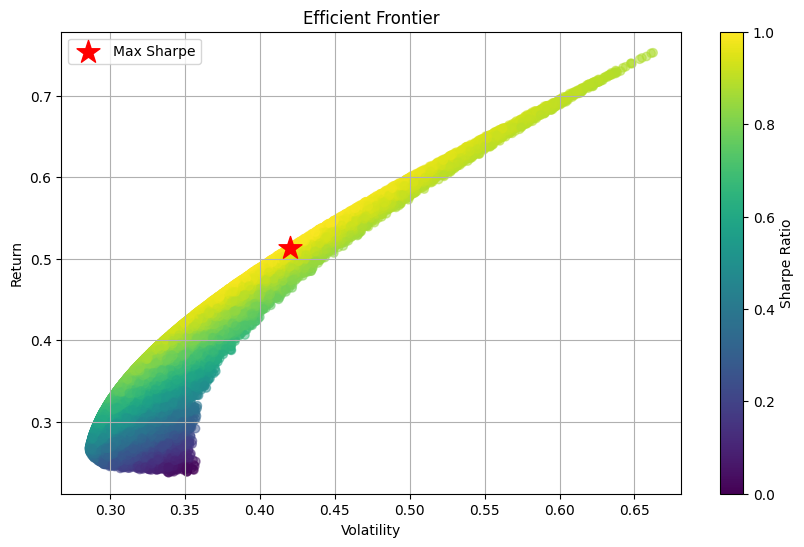

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis', alpha=0.5)
plt.scatter(opt_std, opt_return, color='red', marker='*', s=300, label='Max Sharpe')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.show()

$$
\max \frac{\mathbf{w}^T \mu - r_f}{\sqrt{\mathbf{w}^T \Sigma \mathbf{w}}}
$$

\begin{cases}
\min \mathbf{w}^T \Sigma \mathbf{w} & \text{(минимизация риска)} \\
\mathbf{w}^T \mu \geq \mu_0 & \text{(ожидаемая доходность)} \\
\sum w_i = 1, \ w_i \geq 0 & \text{(бюджет, long-only)}
\end{cases}